In [1]:
!nvidia-smi

Sun Dec 29 20:57:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8               2W / 140W |    165MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
def mul(*v):
    ret=1
    for x in v:
        ret*=x
    return ret

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm

from torchsummary import summary
from matplotlib import pyplot as plt
import numpy as np
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu") #gpu driver error, switch to cpu for now
device

device(type='cuda')

In [4]:
l = torchvision.datasets.MNIST(root='./mnist_data/', train = True, download = True, transform = transforms.ToTensor())
t = torchvision.datasets.MNIST(root='./mnist_data/', train = False, download = True, transform = transforms.ToTensor())

In [5]:
l.data.shape,l.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [6]:
l.data[0].shape,l.targets[0]

(torch.Size([28, 28]), tensor(5))

In [7]:
img_shape=tuple(l.data[0].shape)
img_dim=mul(*img_shape)
img_shape,img_dim

((28, 28), 784)

In [8]:
x_l=l.data.numpy()
y_l=l.targets.numpy()
x_t=t.data.numpy()
y_t=t.targets.numpy()

In [9]:
IMG_DTYPE=np.float32

#training set
yl=y_l #get selected imgs
xl=x_l.astype(IMG_DTYPE)/255 #color 0~255

#testing set
T_SIZE=1000
yt=y_t[:T_SIZE]
xt=x_t[:T_SIZE].astype(IMG_DTYPE)/255

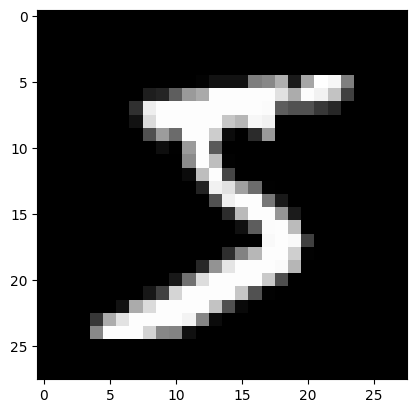

In [10]:
plt.imshow(xl[0], cmap='gray') 

In [11]:
L_BATCH_SIZE=64
T_BATCH_SIZE=100


#create dataloaders
ld=torch.utils.data.DataLoader(
    list(zip(xl,yl)),shuffle=True,batch_size=L_BATCH_SIZE
)
td=torch.utils.data.DataLoader(
    list(zip(xt,yt)),shuffle=True,batch_size=T_BATCH_SIZE
)

In [12]:
Z_DIM=16
MID_DIM=256
class VAE(nn.Module):
    def __init__(self,z_dim=Z_DIM,mid_dim=MID_DIM):
        super().__init__()
        self.fc1 = nn.Linear(img_dim, mid_dim)
        
        self.fc21 = nn.Linear(mid_dim,z_dim) #mu (mean)
        self.fc22 = nn.Linear(mid_dim, z_dim) #sigma (std)


        self.fc3 = nn.Linear(z_dim, mid_dim)
        self.fc4 = nn.Linear(mid_dim,img_dim)
        
    def encode(self,x):
        x=torch.relu(self.fc1(x))
        return self.fc21(x),self.fc22(x)

    def decode(self,x):
        return F.sigmoid(
            self.fc4(
                torch.relu(
                    self.fc3(x)
                )
            )
        )

    def forward(self, x):
        mu, log_std = self.encode(
            x.view(-1, img_dim)
        )
        std = torch.exp(log_std*0.5)
        e = torch.randn_like(std)
        return self.decode(mu+std*e),mu,std,log_std

In [13]:
def loss_fn(x, y, mu, std, log_std): 
    '''BCE + KLD'''
    return F.binary_cross_entropy(y, x.view(-1, img_dim), reduction='sum') + \
        torch.sum(1 + log_std - mu**2 - std**2)* -0.5

In [14]:
model=VAE().to(device)
op=torch.optim.Adam(
    model.parameters(),
    lr=0.002
)

In [15]:
model

VAE(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc21): Linear(in_features=256, out_features=16, bias=True)
  (fc22): Linear(in_features=256, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
)

In [16]:
def l_step(
    model: torch.nn.Module,
    dl: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    op: torch.optim.Optimizer,
    epochs:int=50
):
    # Put model in train mode
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx,(x,_) in enumerate(dl):
            x=x.to(device)

            # 1. Forward pass
            y,mu,std,log_std = model(x)

            # 2. Caculate the loss
            loss=loss_fn(x,y,mu,std,log_std)

            # 3. Optimizer zero grad
            op.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            op.step()

            epoch_loss+=loss.item()
        
        if epoch%4==0:
            print(epoch_loss)
            
    model.eval()


In [17]:
l_step(
    model,
    ld,
    loss_fn,
    op,
    50
)

8582150.307128906
6595809.7216796875
6467724.529296875
6401558.733886719
6356906.764160156
6328177.611083984
6305542.703857422
6284775.326904297
6272827.873779297
6260484.467285156
6251860.703613281
6241970.783447266
6234007.8681640625


In [18]:
model.decode(torch.randn(Z_DIM).to(device)).cpu().detach().numpy()

array([2.94819681e-19, 4.61020584e-19, 5.62177897e-19, 2.68297169e-19,
       3.13085406e-19, 3.85022280e-19, 5.17377278e-19, 5.76375212e-19,
       3.74606938e-19, 3.41509271e-19, 4.48012445e-19, 4.60270228e-19,
       1.45619516e-09, 1.57392286e-08, 1.73716651e-12, 1.85849898e-13,
       3.57513820e-19, 4.22765859e-19, 5.28467909e-19, 4.00642448e-19,
       2.99574393e-19, 3.16976593e-19, 3.36771749e-19, 4.58972743e-19,
       2.11474398e-19, 4.56928884e-19, 4.80394240e-19, 4.73227960e-19,
       3.98814198e-19, 2.55745427e-19, 3.02869907e-19, 2.85728346e-19,
       3.68128770e-19, 5.21862002e-23, 8.86925707e-29, 1.03226661e-12,
       4.31174680e-20, 2.94496563e-15, 4.17002197e-15, 8.71291581e-11,
       1.53057229e-08, 4.80860937e-04, 1.25648512e-03, 1.81959309e-02,
       7.92025216e-03, 3.67643172e-03, 3.23650420e-01, 7.89215386e-01,
       3.71538810e-02, 9.27554211e-04, 8.83684208e-07, 2.91253861e-11,
       4.43871889e-19, 2.55526017e-19, 2.48499945e-19, 2.88382665e-19,
      

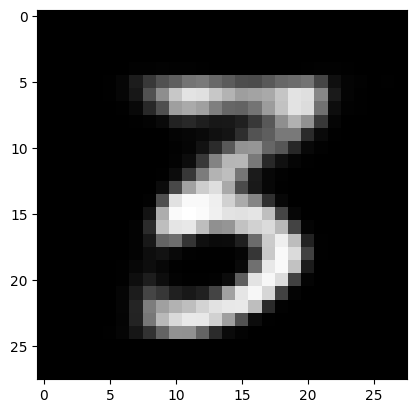

In [75]:
plt.imshow(model.decode(torch.randn(Z_DIM).to(device)).cpu().view(*img_shape).detach().numpy(), cmap='gray') 